# Text analysis

This notebook is the companion for the text analysis chapter (7) of the coursebook *Researching Digital Media and Society* (Lindgren & Eriksson Krutrök, SAGE, 2024).

In this notebook you will find step by step analysis of the Trump Twitter Archive using some of the methods in the chapter.

Before any analysis, the libraries used in the notebook need to be installed.

In [1]:
%pip install pandas matplotlib spacy gensim pyLDAvis vaderSentiment #kagglehub 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Loading libraries and Data

### Loading the libraries used in the analysis
- Take note to run %pip install above before importing the libraries: first we install the libraries, then import them.
- Some libraries are part of Python standard library, so they can be imported without installing them first.

In [2]:
# import kagglehub # used to pull the data
import pandas as pd # for managing the dataset
import os # accessing and managing file systems 
import matplotlib.pyplot as plt # creating plots 
import spacy
import re # for regular expression ie. the standard way computers deal with written text
from collections import Counter # different container for managing text 
import gensim # for topic modelling
from gensim import corpora # for the bag of wrods managing the corpora
import math # self explanatory, the inbuilt math functions
import pyLDAvis.gensim_models as gensimvis # for LDA
import pyLDAvis # visualisation of the LDA
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Sentiment analysis 

### Loading the dataset via the file system or kaggle API

The dataset should be in your home directory, in a file named "tweets.csv". The code below also demonstrates how to pull the data using the kaggle API, an automated way to access datasets for computational analysis from Python. The kaggle API code is commented out, but you can try it after completing the notebook.

In [3]:
# path = kagglehub.dataset_download("headsortails/trump-twitter-archive") # use the kaggle syntax to pull the data
# Alternatively you can download the file from https://www.kaggle.com/datasets/headsortails/trump-twitter-archive
# Unzip the file and put it somewhere sensible like the project directory 
# uncomment this line and fill in your file location file_path = '/location/your_unzipped_dataset'

# print("Path to dataset files:", path) # find where kagglehub put the dataset

# file_path = os.path.join(path, "trump_tweets.csv") # specific the complete path to the dataset

# df = pd.read_csv(file_path) # use the pandas library to open the file as a dataframe
df = pd.read_csv("tweets.csv")
# use the pandas library to open the file as a dataframe
# the index is random, to add some information and make further analysis easier we can set the datetime as the index
df['datetime'] = pd.to_datetime(df['date']) #recode datetime as a datetime variable type instead of text
df.set_index('datetime', inplace=True) # set the index to the datetime variable 

## Initial exploration and Data cleaning

### Taking a first looks, exploratory analysis of the data

In [4]:
print(f"The dataset contains {df.shape[0]} tweets form Trump")
print(f"Each tweet has a variety of attributes, specifically {list(df.columns)}")

df[['favorites','retweets']].describe() # descriptive statistics for the numeric variables
retweet_counts = df['isRetweet'].value_counts() #descriptive statistics for binary/categorical variables
print(retweet_counts)
df[['isFlagged','isDeleted']].value_counts() # descriptives for the categoricals with cross categories

df.head(5) # take a look at the data

The dataset contains 56571 tweets form Trump
Each tweet has a variety of attributes, specifically ['id', 'text', 'isRetweet', 'isDeleted', 'device', 'favorites', 'retweets', 'date', 'isFlagged']
isRetweet
f    46694
t     9877
Name: count, dtype: int64


id  \
datetime                                   
2011-08-02 18:07:48    98454970654916608   
2020-03-03 01:34:50  1234653427789070336   
2020-01-17 03:22:47  1218010753434820614   
2020-09-12 20:10:58  1304875170860015617   
2020-01-17 13:13:59  1218159531554897920   

                                                                  text  \
datetime                                                                 
2011-08-02 18:07:48  Republicans and Democrats have both created ou...   
2020-03-03 01:34:50  I was thrilled to be back in the Great city of...   
2020-01-17 03:22:47  RT @CBS_Herridge: READ: Letter to surveillance...   
2020-09-12 20:10:58  The Unsolicited Mail In Ballot Scam is a major...   
2020-01-17 13:13:59  RT @MZHemingway: Very friendly telling of even...   

                    isRetweet isDeleted              device  favorites  \
datetime                                                                 
2011-08-02 18:07:48         f         f           TweetDeck         49   
2020-03-03 01:34:50         f         f  Twitter for iPhone      73748   
2020-01-17 03:22:47         t         f  Twitter for iPhone          0   
2020-09-12 20:10:58         f         f  Twitter for iPhone      80527   
2020-01-17 13:13:59         t         f  Twitter for iPhone          0   

                     retweets                 date isFlagged  
datetime                                                      
2011-08-02 18:07:48       255  2011-08-02 18:07:48         f  
2020-03-03 01:34:50     17404  2020-03-03 01:34:50         f  
2020-01-17 03:22:47      7396  2020-01-17 03:22:47         f  
2020-09-12 20:10:58     23502  2020-09-12 20:10:58         f  
2020-01-17 13:13:59      9081  2020-01-17 13:13:59         f

## Analysis

### Content Analysis
We take a look at the occurance of fake news, you can change the key to anything else 

First off we can create some simple analysis just using some basic regular expression. Regular expression is a powerful tool in text analysis for extracting specific patterns from text data 

In [ ]:
# create new variables counting the occurance of a specific phrase within a document(in this case document = one tweet)
df['fake_news_count'] = df["text"].str.lower().str.count(r"fake news") # r prefix lets python know to treat input as string litteral ie. keep the backslashes instead of escaping the next character
df['fake_count'] = df["text"].str.lower().str.count(r"fake") # you can look for different strings or substrings because maybe there are some cases you missed
df['news_count'] = df["text"].str.lower().str.count(r"news")
df['mentions'] = df['text'].str.findall(r'@\w+') # this is a bit more complex regex it looks for all the mentions in the tweets
# it looks for substrings starting with the '@' character matching all the [A-Za-z0-9_] characters after is using '\w' the + means we looks for one or more characters until a non match ie. a white space
# regular expression is a powerful method for extracting information one seeks from unstructured text

In [ ]:
# for plotting the extracted info the granularity of the data is not very useful as daily counts are too granular over years of observations
monthly_counts = df.resample('ME')[['fake_news_count', 'fake_count', 'news_count']].sum().reset_index() # resampling the data for 

# Plot the monthly trends for fake_news_count
plt.figure(figsize=(12, 6)) # initalise the plot 
plt.plot(monthly_counts['datetime'], monthly_counts['fake_news_count'], 
         label="Fake News Count", marker='o', linestyle='-') # add line plots one by one
plt.plot(monthly_counts['datetime'], monthly_counts['fake_count'], 
         label="Fake Count", marker='o', linestyle='-')
plt.plot(monthly_counts['datetime'], monthly_counts['news_count'], 
         label="News Count", marker='o', linestyle='-')

# Formatting the plot
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Monthly Occurrences of 'Fake News', 'Fake', and 'News'")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Breaking things down, Tokenisation

In [ ]:
# Need to download the model we will use with Spacy
spacy.cli.download("en_core_web_sm")

In [ ]:
# for this I will write a small function to tokenise each tweet as well as clean up the text 
# Load the small English model
nlp = spacy.load("en_core_web_sm")


def tokenise(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove mentions
    text = re.sub(r"@\w+", "", text)
    # Remove retweet tags
    text = re.sub(r'rt', "", text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove all punctuation and non-alphabetic characters
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Use spaCy to tokenize the cleaned text
    doc = nlp(text)

    return doc # return the entire resulting dictionary so we can take a look at it and reuse it

# Apply the function to your DataFrame column -- Note that this probably takes a long time!
df['tokenised_text'] = df['text'].apply(tokenise)

print("Tokenised texts look like this:",df['tokenised_text'].iloc[1]) 

In [ ]:
df['tokenised_text'].iloc[1]

In [ ]:
# There is no straightforward command for concordance analysis in spacy that works with phrases so we need to write one
# Note for tweets it would be easier to simply search for the tweets 
# df['text'][df['text'].str.contains("fake news", case=False)]
def concordance_for_phrase(tokens, phrase=None, window=10):
    
    contexts = [] # output container
    phrase_length = len(phrase) # learn the length of the phrase
    for i in range(len(tokens) - phrase_length + 1): # 
        if tokens[i:i+phrase_length] == phrase:
            # Define context boundaries
            start = max(0, i - window)
            end = min(len(tokens), i + phrase_length + window)
            context = tokens[start:end]
            contexts.append(" ".join(context))
    return contexts

# Then loop through all the tweets 
all_concordances = []
for doc in df['tokenised_text']:
    # Convert the Doc to a list of token texts (ignoring whitespace)
    tokens_list = [token.text for token in doc if not token.is_space]
    contexts = concordance_for_phrase(tokens_list, phrase=["fake", "news"])
    if contexts:
        all_concordances.extend(contexts)

# Print the first 10 concordances
for context in all_concordances[:10]:
    print("-", context)


In [ ]:
def collocations_for_target(tokens, target, window=3):
    collocations = []
    for i, token in enumerate(tokens):
        if token == target:
            # Determine context window (exclude the target token itself)
            start = max(0, i - window)
            end = min(len(tokens), i + window + 1)
            # Exclude the target token
            context = tokens[start:i] + tokens[i+1:end]
            collocations.extend(context)
    return collocations

# Initialize lists to hold collocations for each target across all tweets
hillary_collocations = []
bernie_collocations = []

for doc in df['tokenised_text']:
    tokens = [token.text for token in doc if not token.is_space]
    hillary_collocations.extend(collocations_for_target(tokens, "hillary"))
    bernie_collocations.extend(collocations_for_target(tokens, "bernie"))

# Count the frequency of collocates
hillary_freq = Counter(hillary_collocations)
bernie_freq = Counter(bernie_collocations)

# Display the 10 most common collocations for each target
print("\nTop 10 collocations for 'hillary':")
for word, count in hillary_freq.most_common(10):
    print(f"{word}: {count}")

print("\nTop 10 collocations for 'bernie':")
for word, count in bernie_freq.most_common(10):
    print(f"{word}: {count}")


### Part of Speech tagging and Named entity recognition

For the next steps we need to tokenise the texts this means we break the text up to smaller parts to analyse it as data.

In [ ]:
# We can use dictionary comprehension to find all adjectives
adjectives = [token.text.lower() for doc in df['tokenised_text'] for token in doc if token.pos_ == 'ADJ']

# Get the 10 most common adjectives
top_adjectives = Counter(adjectives).most_common(10) # then we can count all the adjectives 
print(top_adjectives)

In [ ]:
# Extract entities as tuples using comprehensions
entities = [(ent.text, ent.label_) for doc in df['tokenised_text'] for ent in doc.ents]

# Get the 10 most common entities
top_entities = Counter(entities).most_common(10)
print("Top 10 entities (text, label):")
for entity, count in top_entities:
    print(entity, count)


### Topic Modelling and Word Embedding

In [ ]:
# Convert each spaCy Doc into a list of tokens 
def unwrap_doc(doc):
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

# Apply the unwrapping function to each tweet
texts_from_doc = df['tokenised_text'].apply(unwrap_doc).tolist()

# Now create the gensim dictionary and corpus
dictionary = corpora.Dictionary(texts_from_doc)
corpus = [dictionary.doc2bow(text) for text in texts_from_doc]


In [ ]:
num_topics = 10  # as an example, you can adjust based on your needs
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics,
                                   random_state=42,
                                   passes=10)

# Print the topics after running the model -- Note that this may take a long time!
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


In [ ]:
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

# Note that the plots are labeled PC1 and PC2 for principal component one and two 
# This is a mapping from the multidimensional vector space via principal component analysis, that is selecting the hyperplanes that best seperate the data

### Sentiment analysis

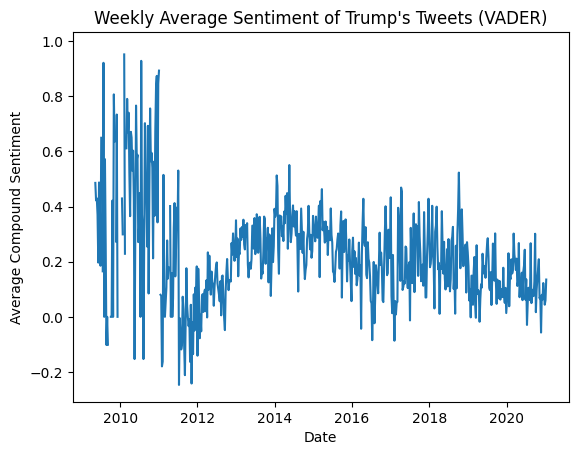

In [5]:
analyzer = SentimentIntensityAnalyzer() # load the function

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores  # this returns a dict with 'neg', 'neu', 'pos', and 'compound'

df['sentiment'] = df['text'].apply(get_sentiment) # again we use apply to run through the whole 
# For example, extract the compound score
df['compound'] = df['sentiment'].apply(lambda x: x['compound'])

# Plot weekly average sentiment over time
weekly_sentiment = df['compound'].resample('W').mean()
plt.plot(weekly_sentiment.index, weekly_sentiment.values)
plt.xlabel("Date")
plt.ylabel("Average Compound Sentiment")
plt.title("Weekly Average Sentiment of Trump's Tweets (VADER)")
plt.show()
